In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import seaborn as sns
import pickle

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
from exp_spatialdm import spatialdm
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')
spec = "human"
ST_name = "intestine5fold"
pre_datapath = "../../output/preprocessed_dataset/intestine.pkl"
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
cls_key = 'leiden'
classes = scrna_adata.obs[cls_key]
ct_list = np.unique(classes)    

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

test_gene_set = []
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpLR = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_gene_set.append(test_gene)
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpLR[test_gene] = expTransImp(
                    df_ref=raw_scrna_df,
                    df_tgt=raw_spatial_df,
                    train_gene=train_gene,
                    test_gene=test_gene,
                    signature_mode='cell',
                    mapping_mode='lowrank',
                    n_epochs=2000,
                    seed=seed,
                    device=device
    )
    corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpLR_res)} (TransImpLR)')    
    
    df_transImpSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                clip_max=0.1,
                n_epochs=2000,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpSpa_res)} (TransImpSpa)')
    
    df_transImpCls[test_gene] = expTransImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            train_gene=train_gene,
            test_gene=test_gene,
            ct_list=ct_list,
            classes=classes,
            n_epochs=2000,
            signature_mode='cluster',
            mapping_mode='full',
            seed=seed,
            device=device)

    corr_transImp_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImp_res)} (TransImpCls)')
    
    
    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_0-y", verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(scrna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_res_tangram)} (Tangram)')


===== Fold 1 =====
Number of train genes: 5593, Number of test genes: 1399


[TransImp] Epoch: 2000/2000, loss: 0.938483, (IMP) 0.938483: 100%|██████████| 2000/2000 [00:54<00:00, 36.40it/s]


fold 0, median cosine similarity: 0.2704130184898761 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 1.078024, (IMP) 1.077976, (SPA) 1.0 x 0.000048: 100%|██████████| 2000/2000 [01:22<00:00, 24.14it/s]


fold 0, median cosine similarity: 0.24971076183109364 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.018848, (IMP) 1.018848: 100%|██████████| 2000/2000 [00:14<00:00, 137.31it/s]


fold 0, median cosine similarity: 0.27868956693485325 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.035403, (IMP) 1.030873, (SPA) 1.0 x 0.004530: 100%|██████████| 2000/2000 [00:28<00:00, 70.28it/s]


fold 0, median cosine similarity: 0.2712562041266695 (TransImpClsSpa)
fold 0, median cosine similarity: 0.25815297904920476 (stPlus)
fold 0, median cosine similarity: 0.2520652386666733 (spaGE)


INFO:root:5593 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5593 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5593 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.270, KL reg: 0.097
Score: 0.322, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000


INFO:root:Saving results..


fold 0, median cosine similarity: 0.2797091129769722 (Tangram)

===== Fold 2 =====
Number of train genes: 5593, Number of test genes: 1399


[TransImp] Epoch: 2000/2000, loss: 0.934649, (IMP) 0.934649: 100%|██████████| 2000/2000 [00:28<00:00, 70.18it/s]


fold 1, median cosine similarity: 0.2697096940738196 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 1.073459, (IMP) 1.073449, (SPA) 1.0 x 0.000010: 100%|██████████| 2000/2000 [00:37<00:00, 52.85it/s]


fold 1, median cosine similarity: 0.24868227336480309 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.015266, (IMP) 1.015266: 100%|██████████| 2000/2000 [00:14<00:00, 141.06it/s]


fold 1, median cosine similarity: 0.2745836996362311 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.032132, (IMP) 1.027572, (SPA) 1.0 x 0.004560: 100%|██████████| 2000/2000 [00:24<00:00, 82.59it/s]


fold 1, median cosine similarity: 0.2664726956248509 (TransImpClsSpa)
fold 1, median cosine similarity: 0.25505626040172014 (stPlus)
fold 1, median cosine similarity: 0.25441012822067577 (spaGE)


INFO:root:5593 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5593 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5593 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.270, KL reg: 0.097
Score: 0.323, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000


INFO:root:Saving results..


fold 1, median cosine similarity: 0.2725476474709142 (Tangram)

===== Fold 3 =====
Number of train genes: 5594, Number of test genes: 1398


[TransImp] Epoch: 2000/2000, loss: 0.916943, (IMP) 0.916943: 100%|██████████| 2000/2000 [00:28<00:00, 71.08it/s]


fold 2, median cosine similarity: 0.2619797342374863 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 1.054956, (IMP) 1.054938, (SPA) 1.0 x 0.000018: 100%|██████████| 2000/2000 [00:37<00:00, 53.81it/s]


fold 2, median cosine similarity: 0.24625155194573167 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.997010, (IMP) 0.997010: 100%|██████████| 2000/2000 [00:14<00:00, 142.19it/s]


fold 2, median cosine similarity: 0.26893470021146737 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.014080, (IMP) 1.009234, (SPA) 1.0 x 0.004846: 100%|██████████| 2000/2000 [00:23<00:00, 85.26it/s]


fold 2, median cosine similarity: 0.26349488169212965 (TransImpClsSpa)
fold 2, median cosine similarity: 0.24391792725984385 (stPlus)
fold 2, median cosine similarity: 0.24763450776544466 (spaGE)


INFO:root:5594 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5594 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5594 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.273, KL reg: 0.096
Score: 0.326, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000


INFO:root:Saving results..


fold 2, median cosine similarity: 0.2687535119013012 (Tangram)

===== Fold 4 =====
Number of train genes: 5594, Number of test genes: 1398


[TransImp] Epoch: 2000/2000, loss: 0.912860, (IMP) 0.912860: 100%|██████████| 2000/2000 [00:28<00:00, 70.58it/s]


fold 3, median cosine similarity: 0.2554718586722865 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 1.049156, (IMP) 1.049147, (SPA) 1.0 x 0.000008: 100%|██████████| 2000/2000 [00:37<00:00, 52.93it/s]


fold 3, median cosine similarity: 0.24119577102062156 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.992277, (IMP) 0.992277: 100%|██████████| 2000/2000 [00:14<00:00, 138.40it/s]


fold 3, median cosine similarity: 0.2678411511681585 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.008832, (IMP) 1.004179, (SPA) 1.0 x 0.004653: 100%|██████████| 2000/2000 [00:23<00:00, 84.66it/s]


fold 3, median cosine similarity: 0.25858891870283657 (TransImpClsSpa)
fold 3, median cosine similarity: 0.2420272027927089 (stPlus)
fold 3, median cosine similarity: 0.23915935483144052 (spaGE)


INFO:root:5594 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5594 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5594 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.272, KL reg: 0.096
Score: 0.325, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.326, KL reg: 0.000


INFO:root:Saving results..


fold 3, median cosine similarity: 0.26317890408230826 (Tangram)

===== Fold 5 =====
Number of train genes: 5594, Number of test genes: 1398


[TransImp] Epoch: 2000/2000, loss: 0.914021, (IMP) 0.914021: 100%|██████████| 2000/2000 [00:27<00:00, 71.55it/s]


fold 4, median cosine similarity: 0.26804560231568153 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 1.053233, (IMP) 1.053200, (SPA) 1.0 x 0.000033: 100%|██████████| 2000/2000 [00:37<00:00, 53.78it/s]


fold 4, median cosine similarity: 0.2516754297709285 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.994663, (IMP) 0.994663: 100%|██████████| 2000/2000 [00:13<00:00, 146.07it/s]


fold 4, median cosine similarity: 0.28023904566083085 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.011396, (IMP) 1.006631, (SPA) 1.0 x 0.004765: 100%|██████████| 2000/2000 [00:22<00:00, 88.05it/s]


fold 4, median cosine similarity: 0.2704997848263428 (TransImpClsSpa)
fold 4, median cosine similarity: 0.25663664219173493 (stPlus)
fold 4, median cosine similarity: 0.2534307020747174 (spaGE)


INFO:root:5594 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5594 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5594 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.271, KL reg: 0.096
Score: 0.324, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000


INFO:root:Saving results..


fold 4, median cosine similarity: 0.2775572459978069 (Tangram)


In [4]:
df_transImpLR.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpLR.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [5]:
corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)  
corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)  
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)  

print(np.median(corr_transImpLR_res), "(TransImpLR)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
)

0.2655768533232482 (TransImpLR) 0.27421088450268555 (TransImpCls) 0.24676085993478353 (TransImpSpa) 0.2660521175385683 (TransImpClsSpa) 0.2513846680997222 (stPlus) 0.24987450182244708 (spaGE) 0.27197078553071435 (Tangram)


In [6]:
df_transImpLR = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpLR.csv', index_col=0)
df_transImpSpa = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv', index_col=0)
df_transImpCls = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv', index_col=0)
df_transImpClsSpa = pd.read_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv', index_col=0)
df_spaGE_res = pd.read_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv', index_col=0)
df_stplus_res = pd.read_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv', index_col=0)
df_tangram_res = pd.read_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv', index_col=0)

In [7]:
dict_df = {
            "TransImpLR":df_transImpLR, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


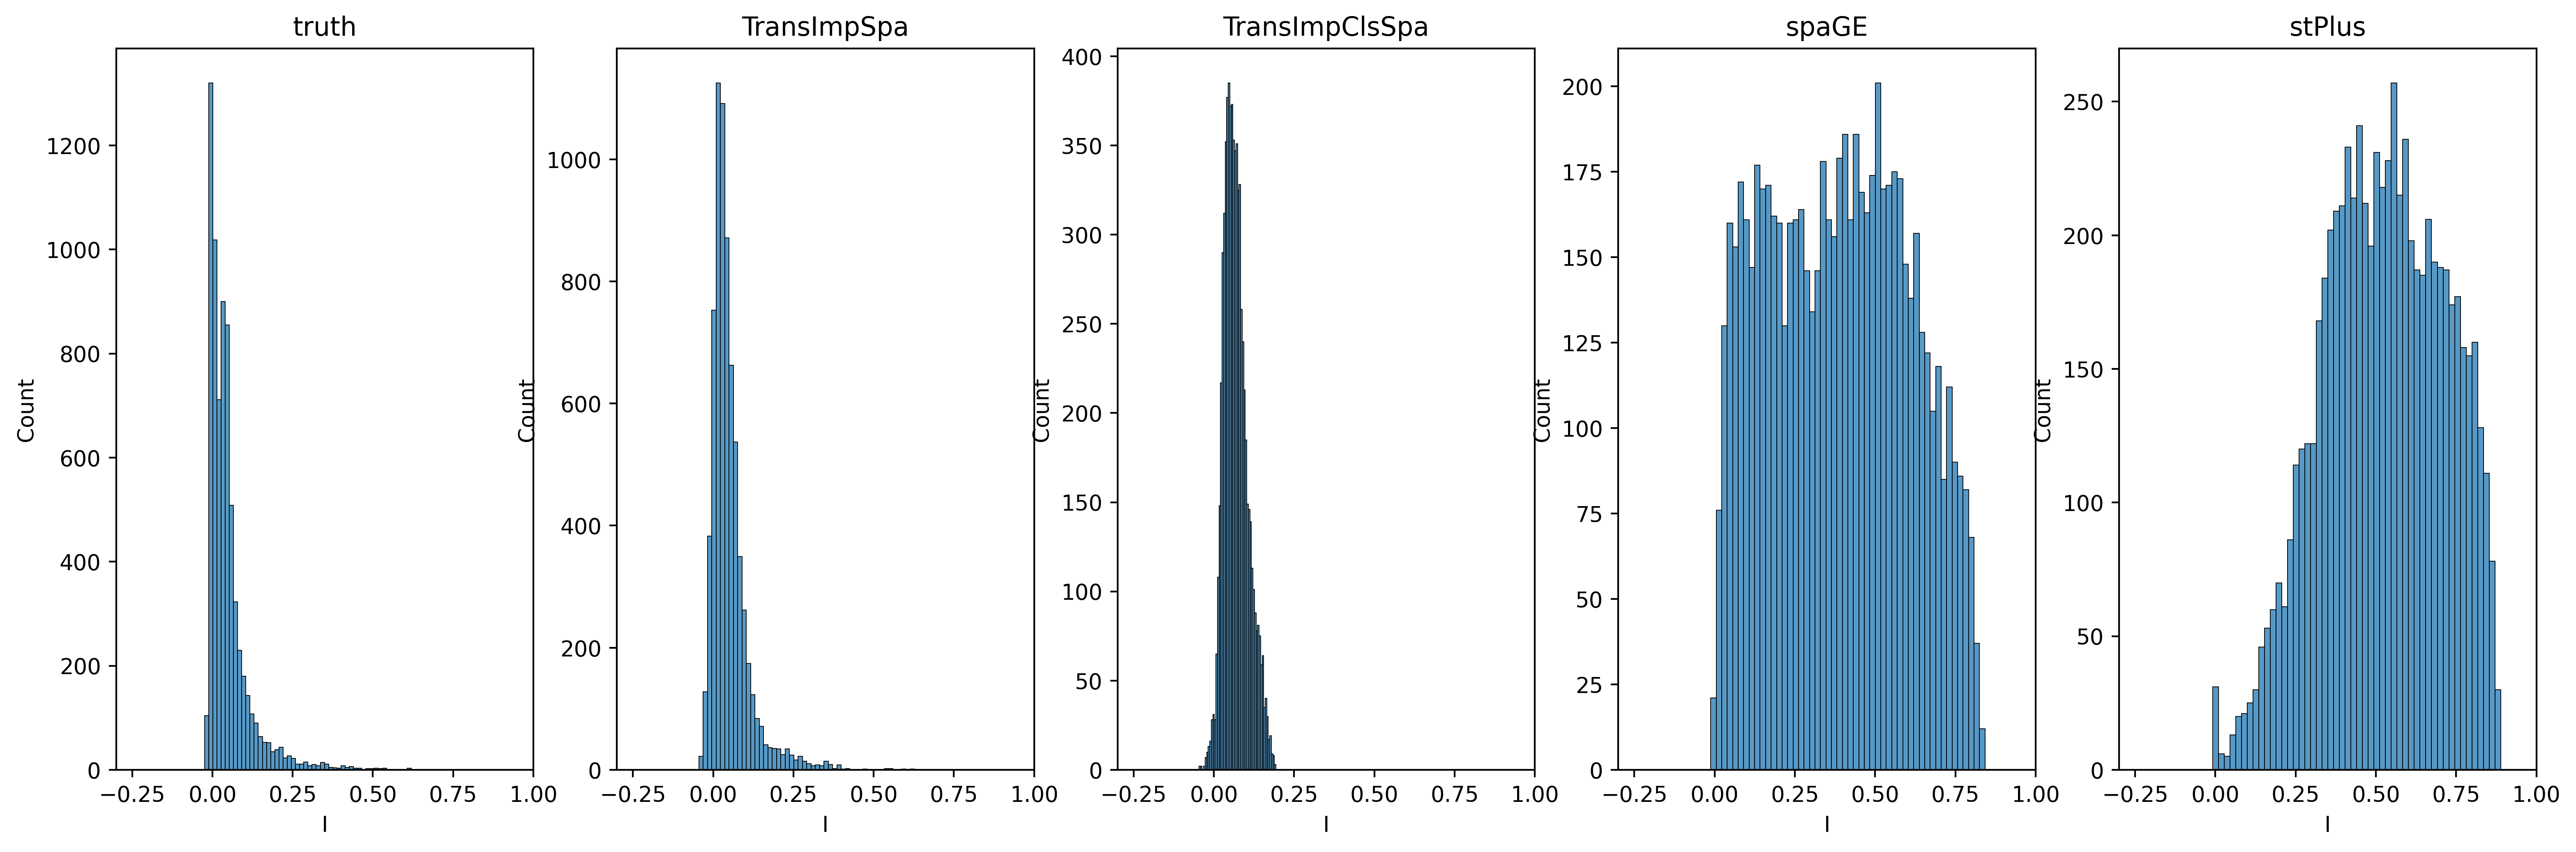

In [8]:
plt.rcParams["figure.dpi"] = 380
plt.rcParams["figure.figsize"] = (20, 6)
fig, axs = plt.subplots(1, 5)
for ax, method in zip(axs, ['truth', 'TransImpSpa', 'TransImpLR', 'spaGE', 'stPlus', 'Tangram']):
    _ax = sns.histplot(dict_adata[method].uns['moranI'].I, ax=ax, bins=50)
    _ax.set_title(f"{method}")
    _ax.set_xlim(-0.3, 1.0)

In [9]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImpLR: 0.214992
	True vs TransImpSpa: 0.002671
	True vs TransImpCls: 0.338020
	True vs TransImpClsSpa: 0.004968
	True vs spaGE: 0.155324
	True vs Tangram: 0.277677
	True vs truth: 0.000000


In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle

from scipy import sparse
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
from plotting import plot_curve_MI, plot_curve_SPARKX, plot_curve_SDM
import warnings

color = ['#c780e8', '#845B53', '#D684BD', '#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2',  ]
methods = ['truth', 'TransImpSpa', 'TransImpClsSpa', 'TransImpLR', 'TransImpCls', 'spaGE', 'stPlus',  'Tangram', ]
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [11]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


In [12]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

,Tangram,TransImpCls,TransImpClsSpa,TransImpLR,TransImpSpa,spaGE,stPlus,truth
A1BG,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,0.000037
A1CF,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,0.000058
AADAT,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,0.477510
AAED1,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,0.269832
AASDH,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,0.021778
...,...,...,...,...,...,...,...,...
ZSWIM1,1.110859e-16,0.000000e+00,0.003895,0.496650,0.001219,0.300033,NaN,0.009435
ZSWIM4,5.553498e-15,0.000000e+00,0.000395,0.469910,0.001084,0.286610,NaN,0.326200
ZXDB,4.038451e-10,0.000000e+00,0.000266,0.429477,0.000895,0.238810,NaN,0.432086
ZYX,1.109406e-09,0.000000e+00,0.000105,0.419251,0.000454,0.204823,NaN,0.000000


(TransImpSpa) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (3388/5652)
(TransImpClsSpa) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5112/5652)
(TransImpLR) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5631/5652)
(TransImpCls) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5652/5652)
(spaGE) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5591/5652)
(stPlus) Valid genes: 5639/6992, Ground Sig/Total (3764/5639), Pred Sig/total (0/5639)
(Tangram) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5652/5652)


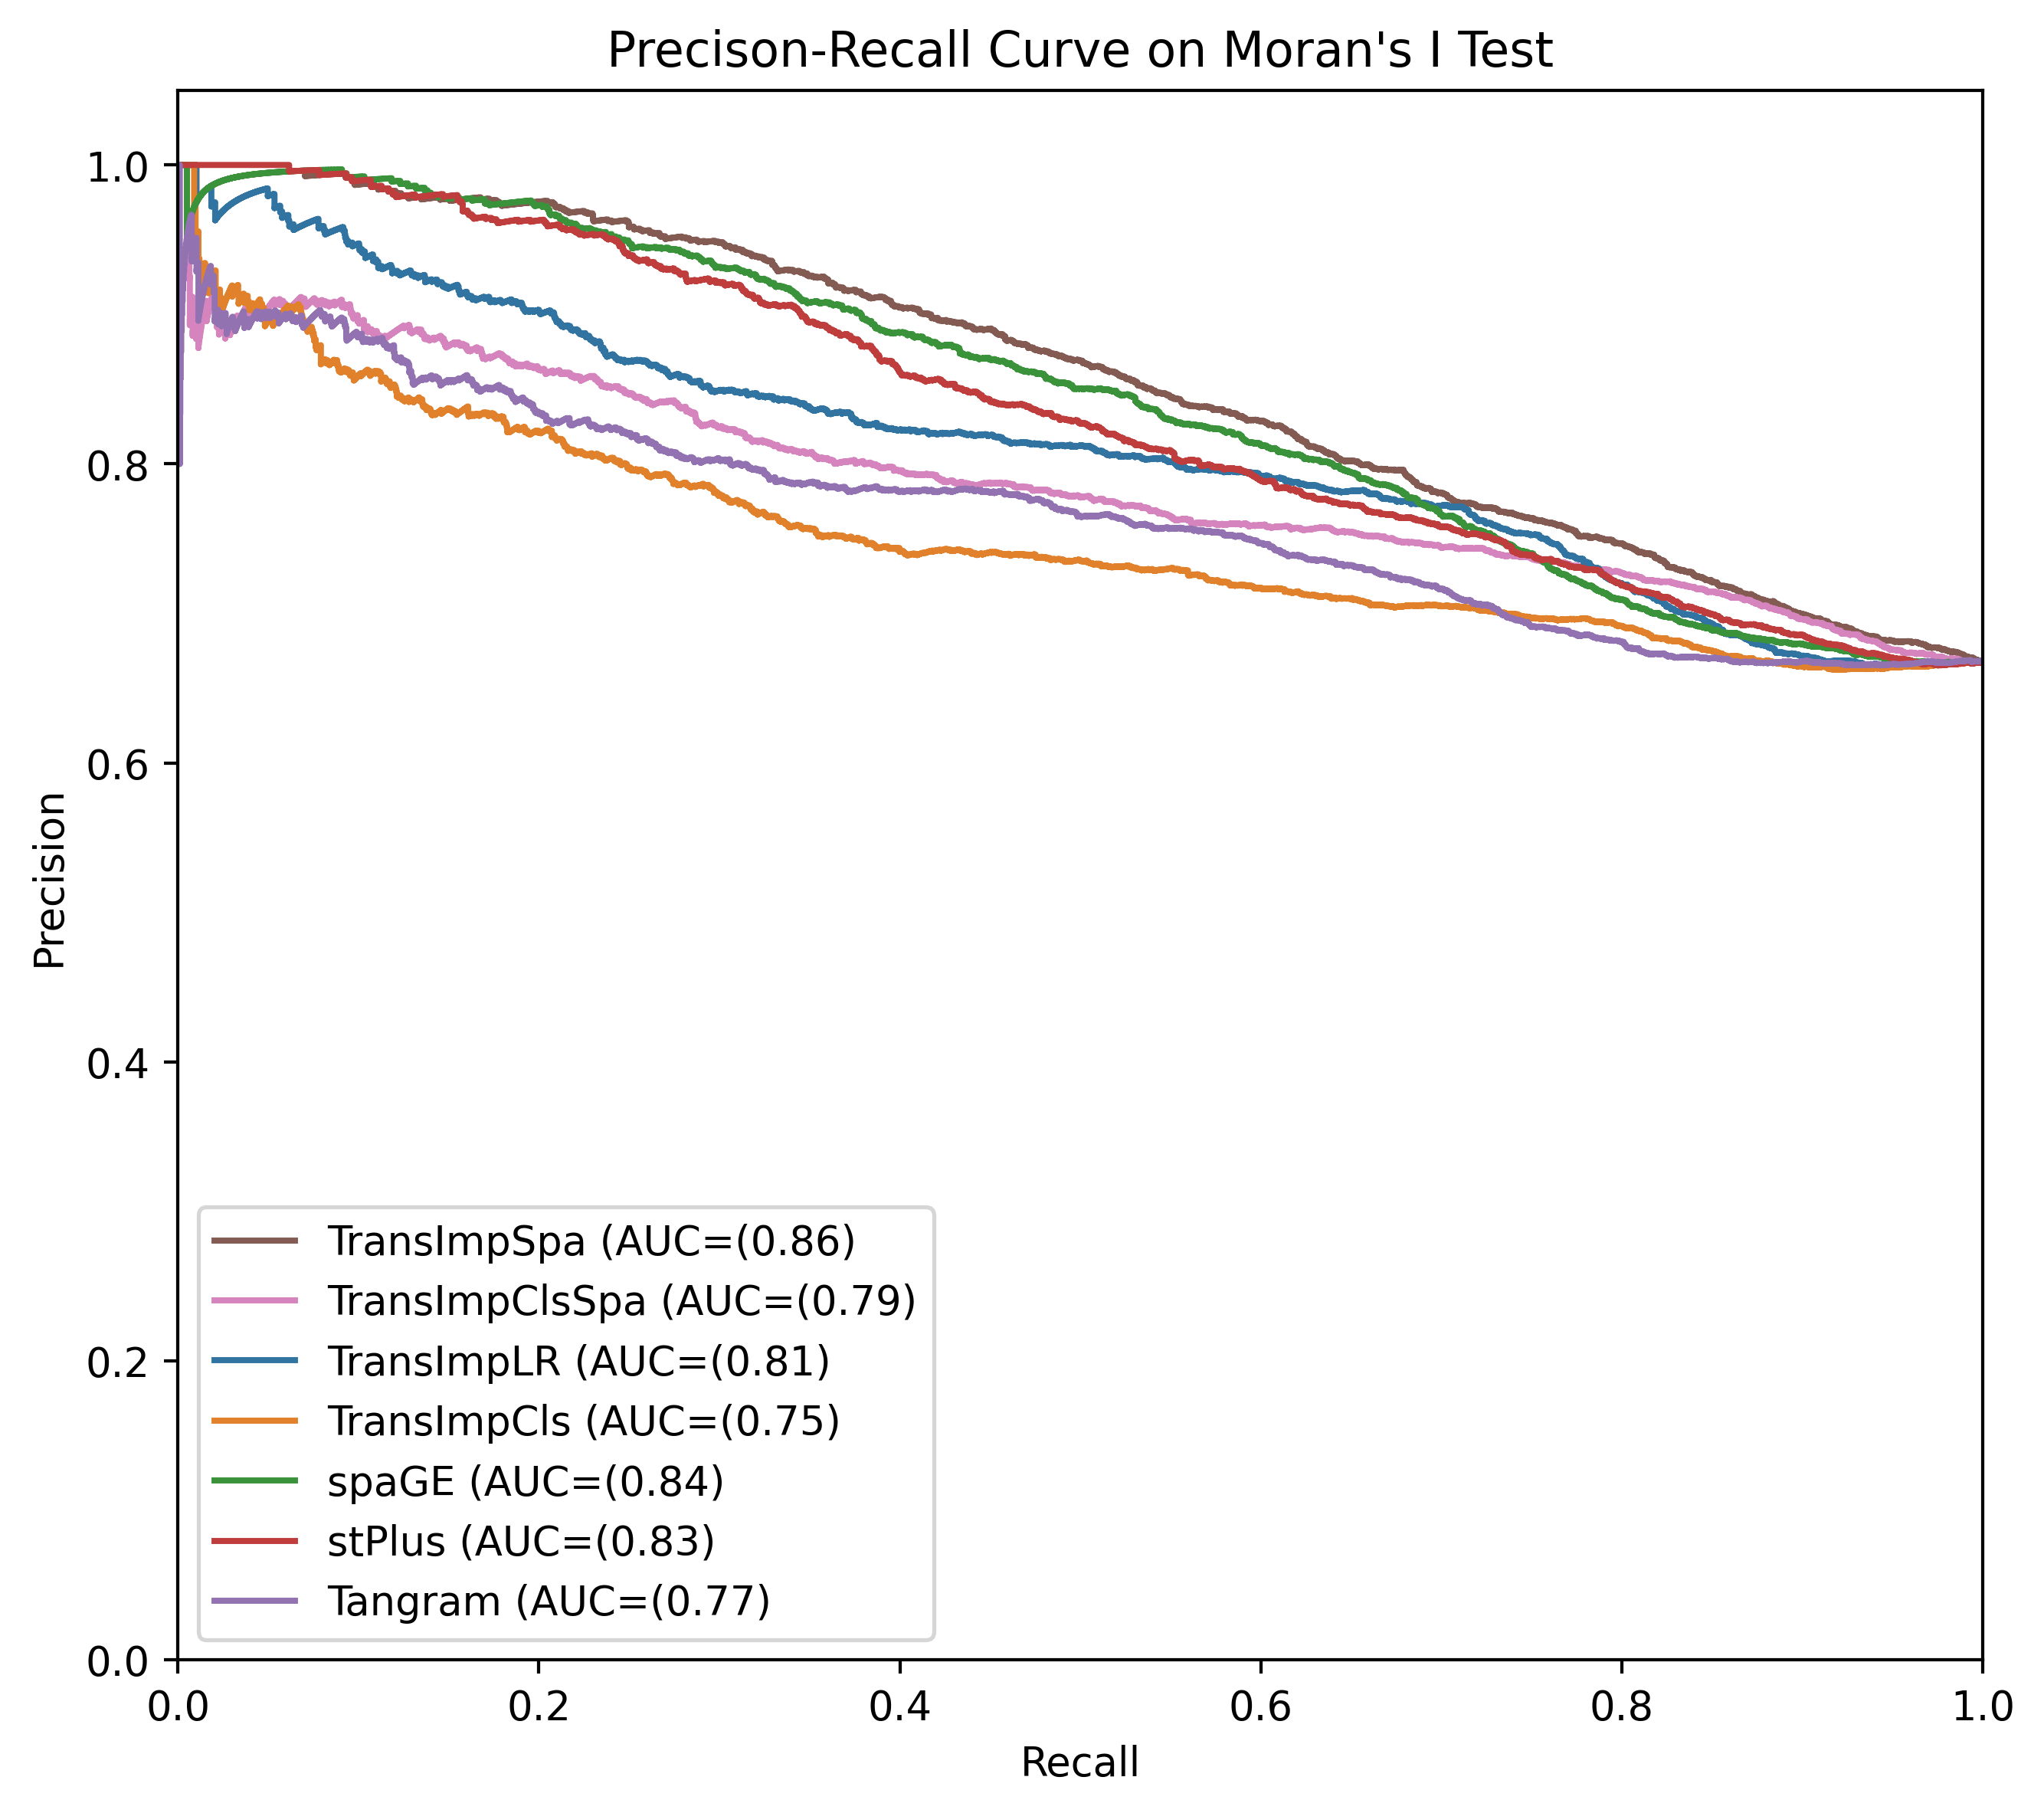

In [13]:
plot_curve_MI(df_corr, 
              df_I, 
              df_fdr, 
              methods, 
              color, 
              "prec_rec",
              thred=thred, 
              excluded_items={'truth'})

(TransImpSpa) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (3388/5652)
(TransImpClsSpa) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5112/5652)
(TransImpLR) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5631/5652)
(TransImpCls) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5652/5652)
(spaGE) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5591/5652)
(stPlus) Valid genes: 5639/6992, Ground Sig/Total (3764/5639), Pred Sig/total (0/5639)
(Tangram) Valid genes: 5652/6992, Ground Sig/Total (3774/5652), Pred Sig/total (5652/5652)


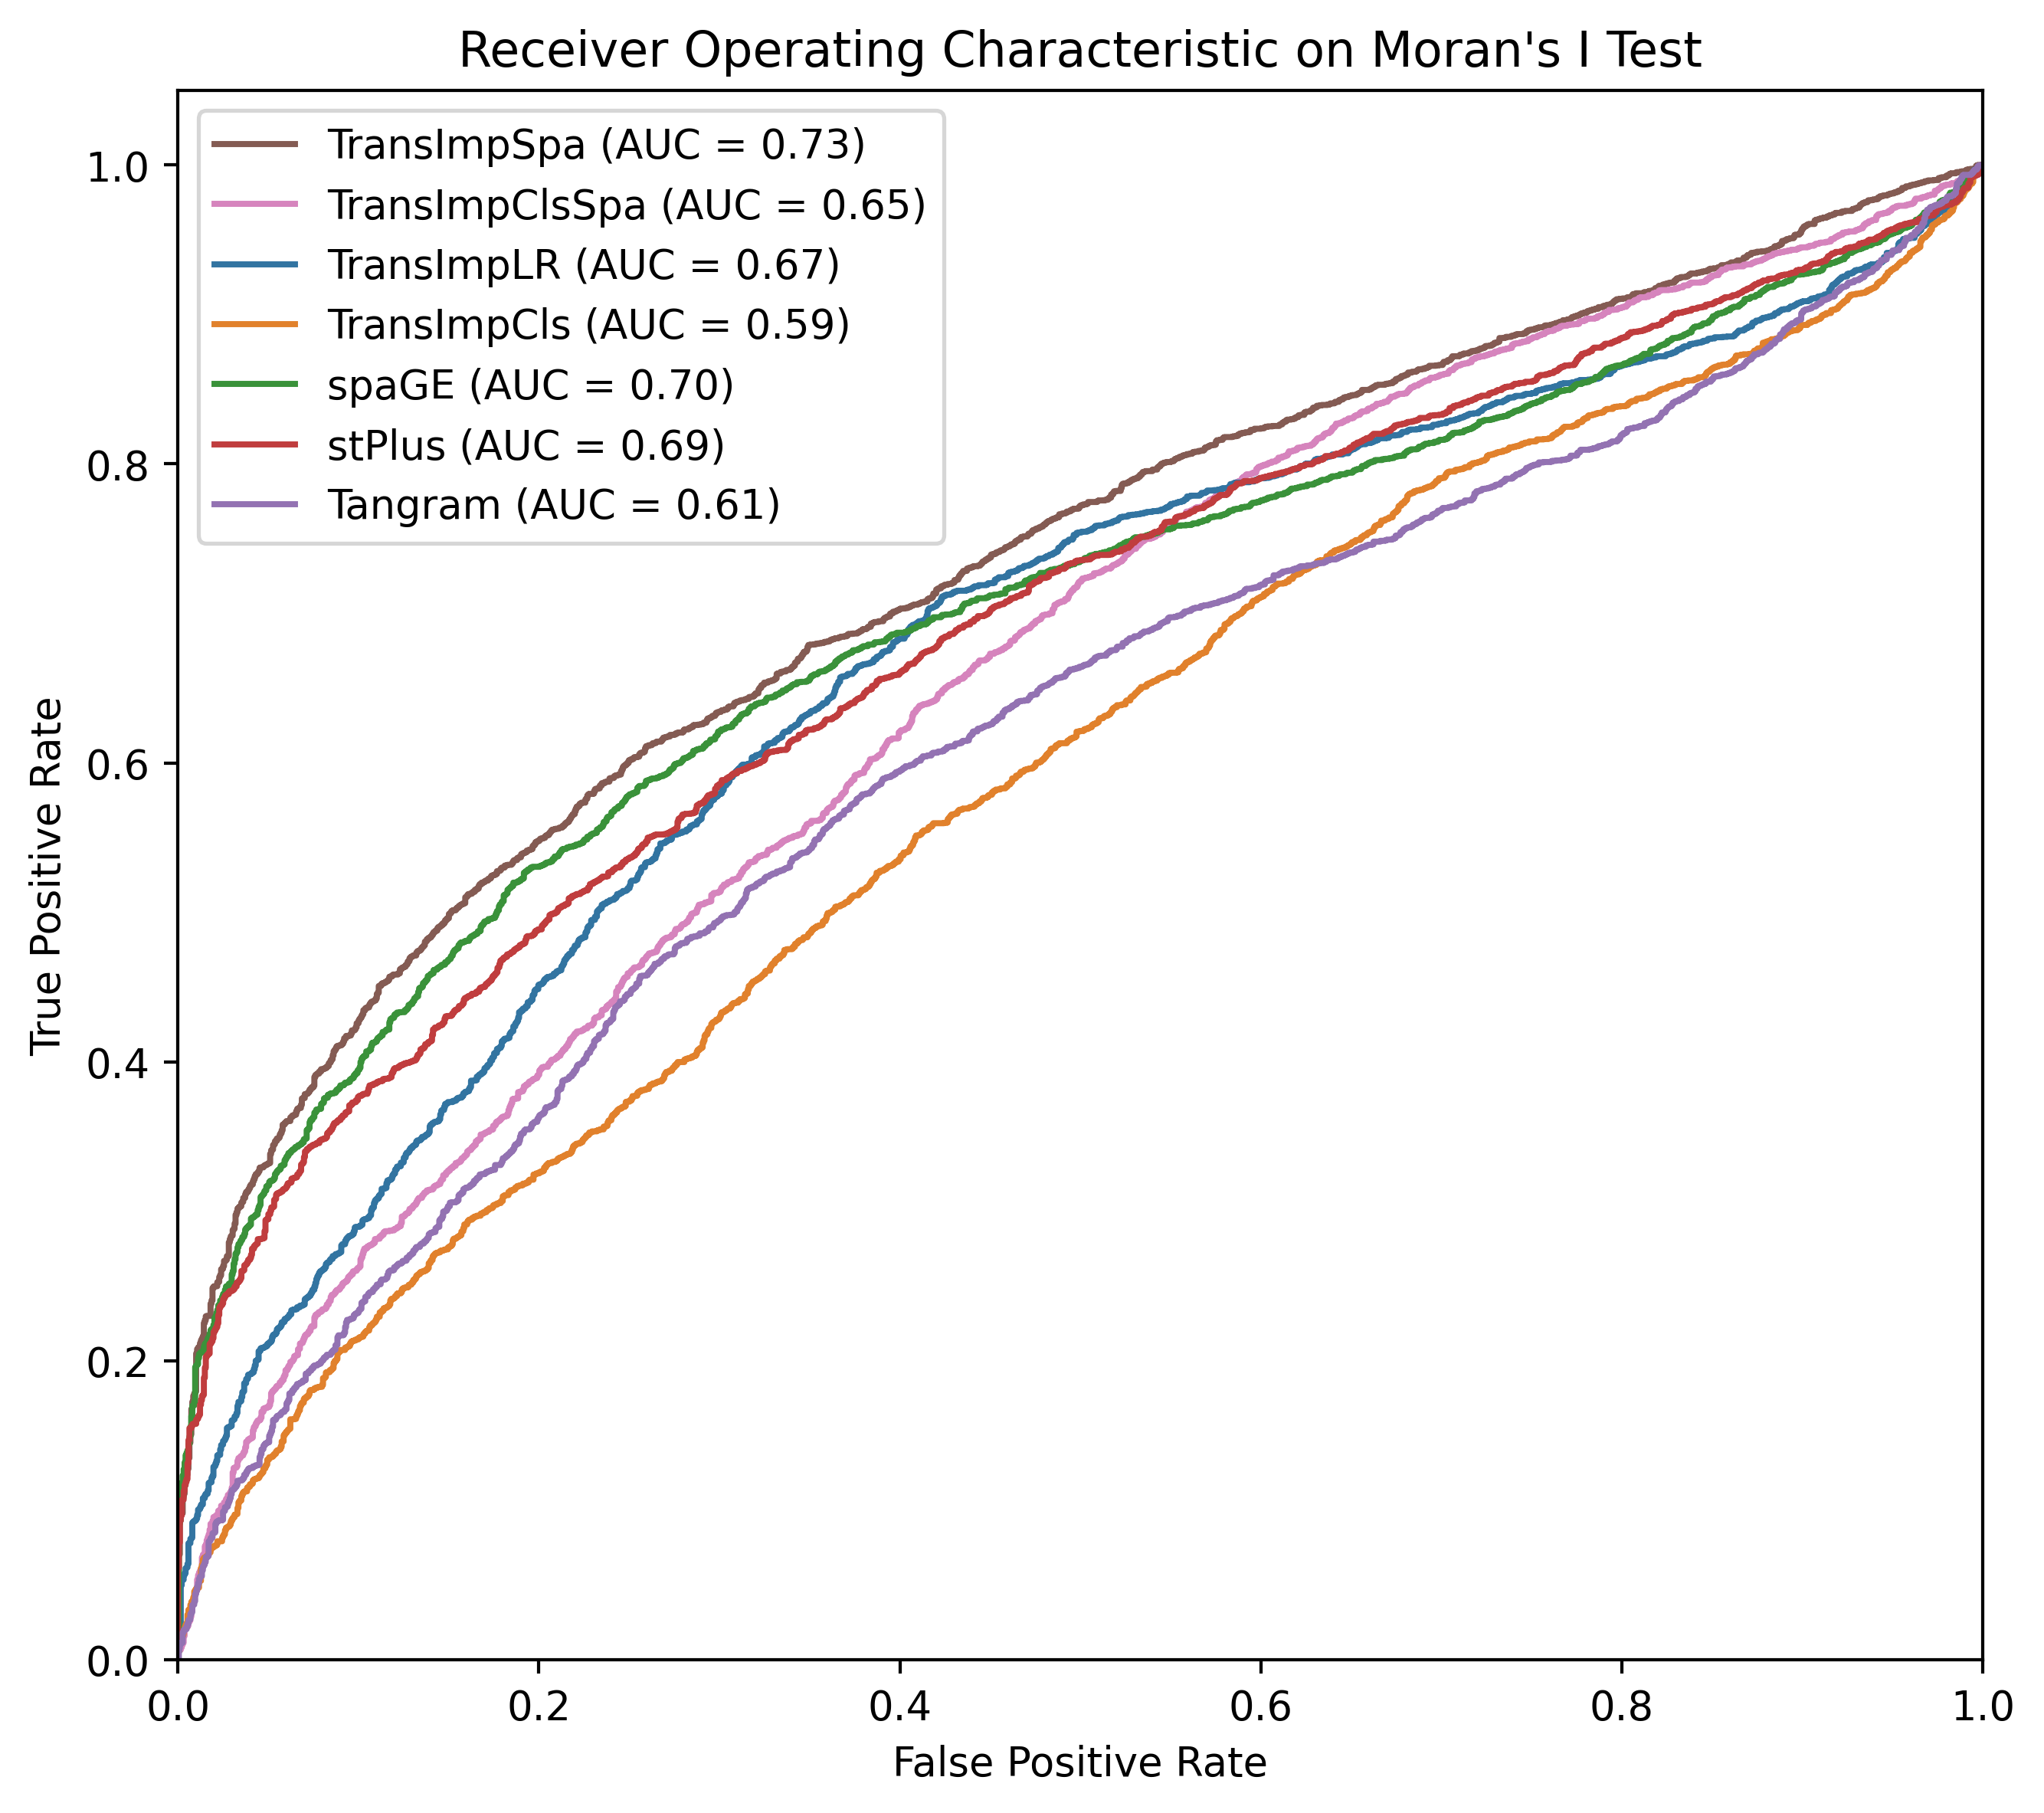

In [14]:
plot_curve_MI(df_corr, 
              df_I, 
              df_fdr, 
              methods, 
              color, 
              "roc",
              thred=thred, 
              excluded_items={'truth'})

In [15]:
# !Rscript sparkX.r
!source /home/cqiao/.bashrc; ~/R/bin/Rscript sparkX.r intestine5fold

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2649 
## number of total genes: 6992 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2649 
## number of total genes: 6972 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Test

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_adjpvals
    

truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram


,truth,TransImpSpa,TransImpClsSpa,TransImpLR,TransImpCls,spaGE,stPlus,Tangram
A1BG,4.205383e-02,1.103373e-02,3.517884e-04,7.279933e-03,3.396628e-13,2.550103e-01,7.757129e-48,1.523224e-12
A1CF,3.137457e-05,5.886901e-25,2.223172e-45,1.106403e-96,1.283871e-128,2.670671e-103,4.058875e-143,1.663108e-100
AADAT,1.000000e+00,9.973984e-02,1.947687e-13,5.035566e-39,9.048574e-40,6.637258e-20,6.625116e-14,2.063386e-23
AAED1,1.000000e+00,1.940247e-01,8.642009e-09,2.075744e-12,4.487365e-23,1.735326e-18,5.548538e-23,1.452466e-36
AASDH,1.000000e+00,7.937930e-03,3.225239e-12,8.006651e-25,8.911845e-34,4.839965e-19,3.510981e-42,1.839501e-33
...,...,...,...,...,...,...,...,...
ZSWIM1,1.000000e+00,1.279591e-01,3.754514e-39,1.071984e-104,4.979803e-114,9.187544e-32,1.899795e-54,7.677050e-59
ZSWIM4,1.000000e+00,9.833690e-01,3.229310e-07,1.253443e-06,2.354131e-25,7.659274e-05,5.799408e-02,3.640418e-27
ZXDB,1.000000e+00,1.348662e-01,9.358180e-12,1.405056e-28,1.264767e-33,2.349832e-08,1.799854e-50,1.802771e-21
ZYX,1.977206e-06,7.391545e-05,4.140476e-15,3.587942e-58,1.558668e-41,5.289789e-07,1.249426e-12,1.726278e-32


(TransImpSpa) Valid genes: 6992/6992
(TransImpClsSpa) Valid genes: 6992/6992
(TransImpLR) Valid genes: 6992/6992
(TransImpCls) Valid genes: 6992/6992
(spaGE) Valid genes: 6992/6992
(stPlus) Valid genes: 6992/6992
(Tangram) Valid genes: 6992/6992


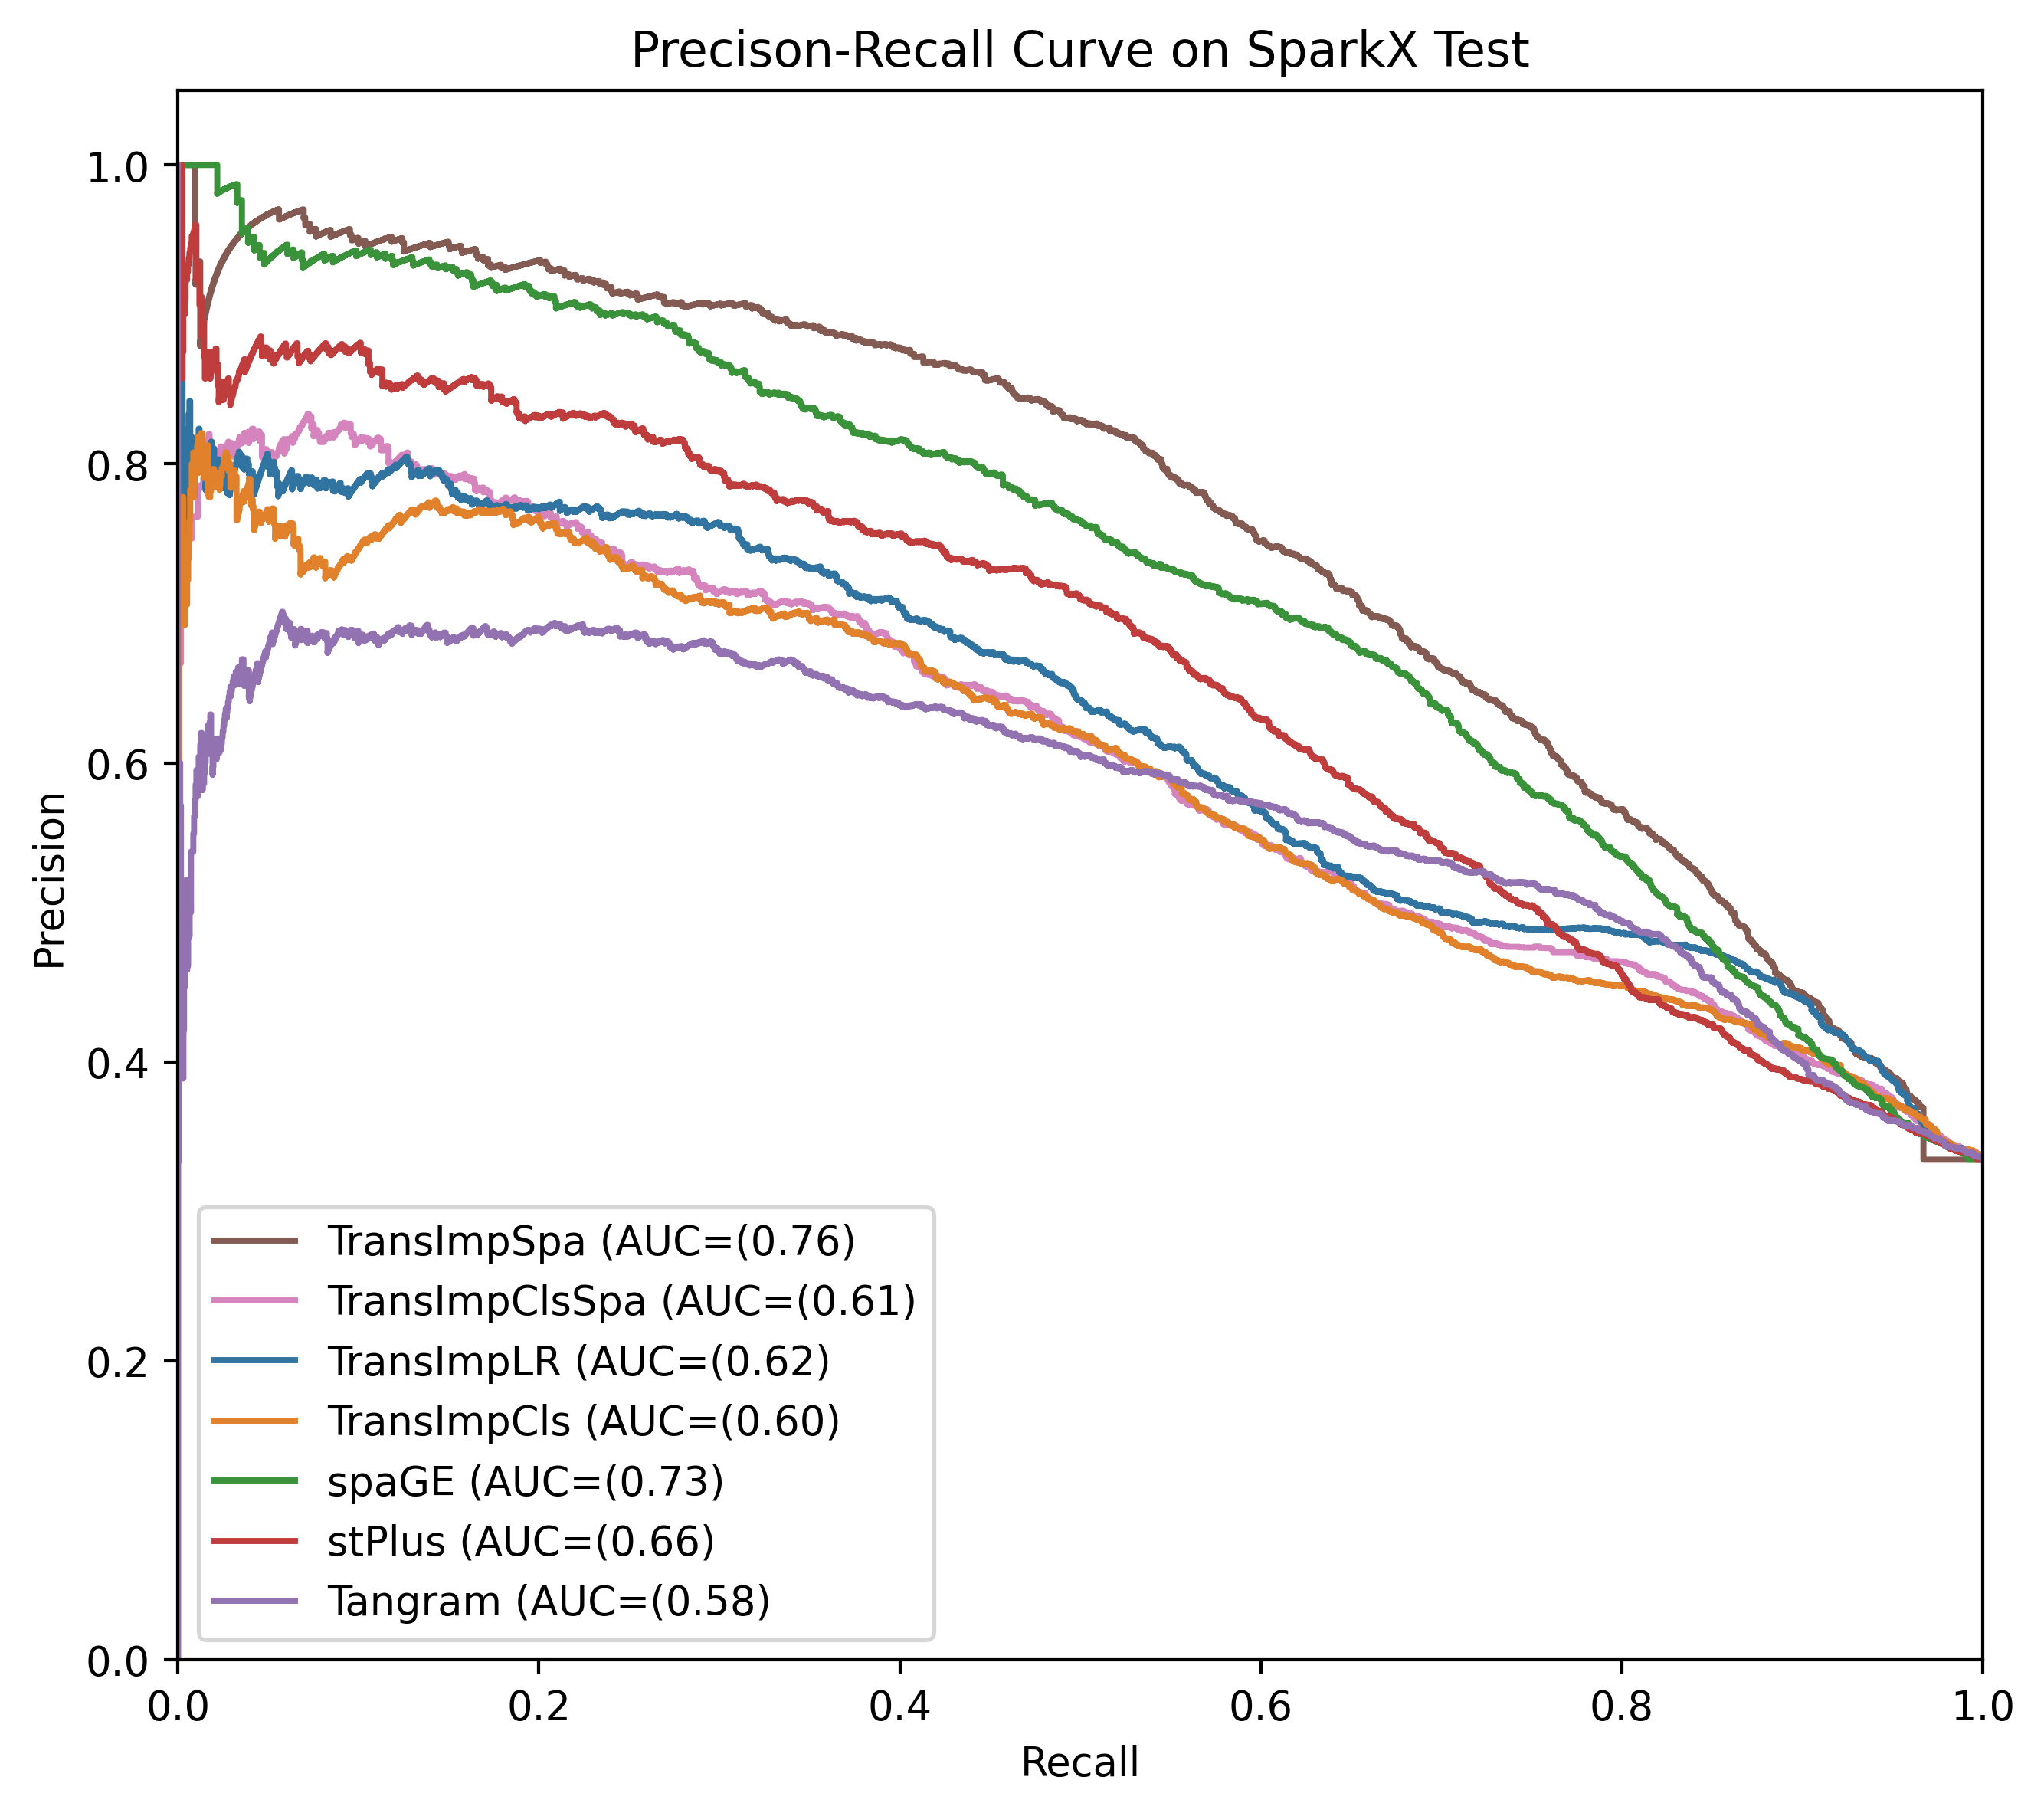

In [17]:
plot_curve_SPARKX(
                  df_sparkx_adjpvals,
                  methods, 
                  color, 
                  'prec_rec',
                  thred=0.01,
                  excluded_items={'truth'})

(TransImpSpa) Valid genes: 6992/6992
(TransImpClsSpa) Valid genes: 6992/6992
(TransImpLR) Valid genes: 6992/6992
(TransImpCls) Valid genes: 6992/6992
(spaGE) Valid genes: 6992/6992
(stPlus) Valid genes: 6992/6992
(Tangram) Valid genes: 6992/6992


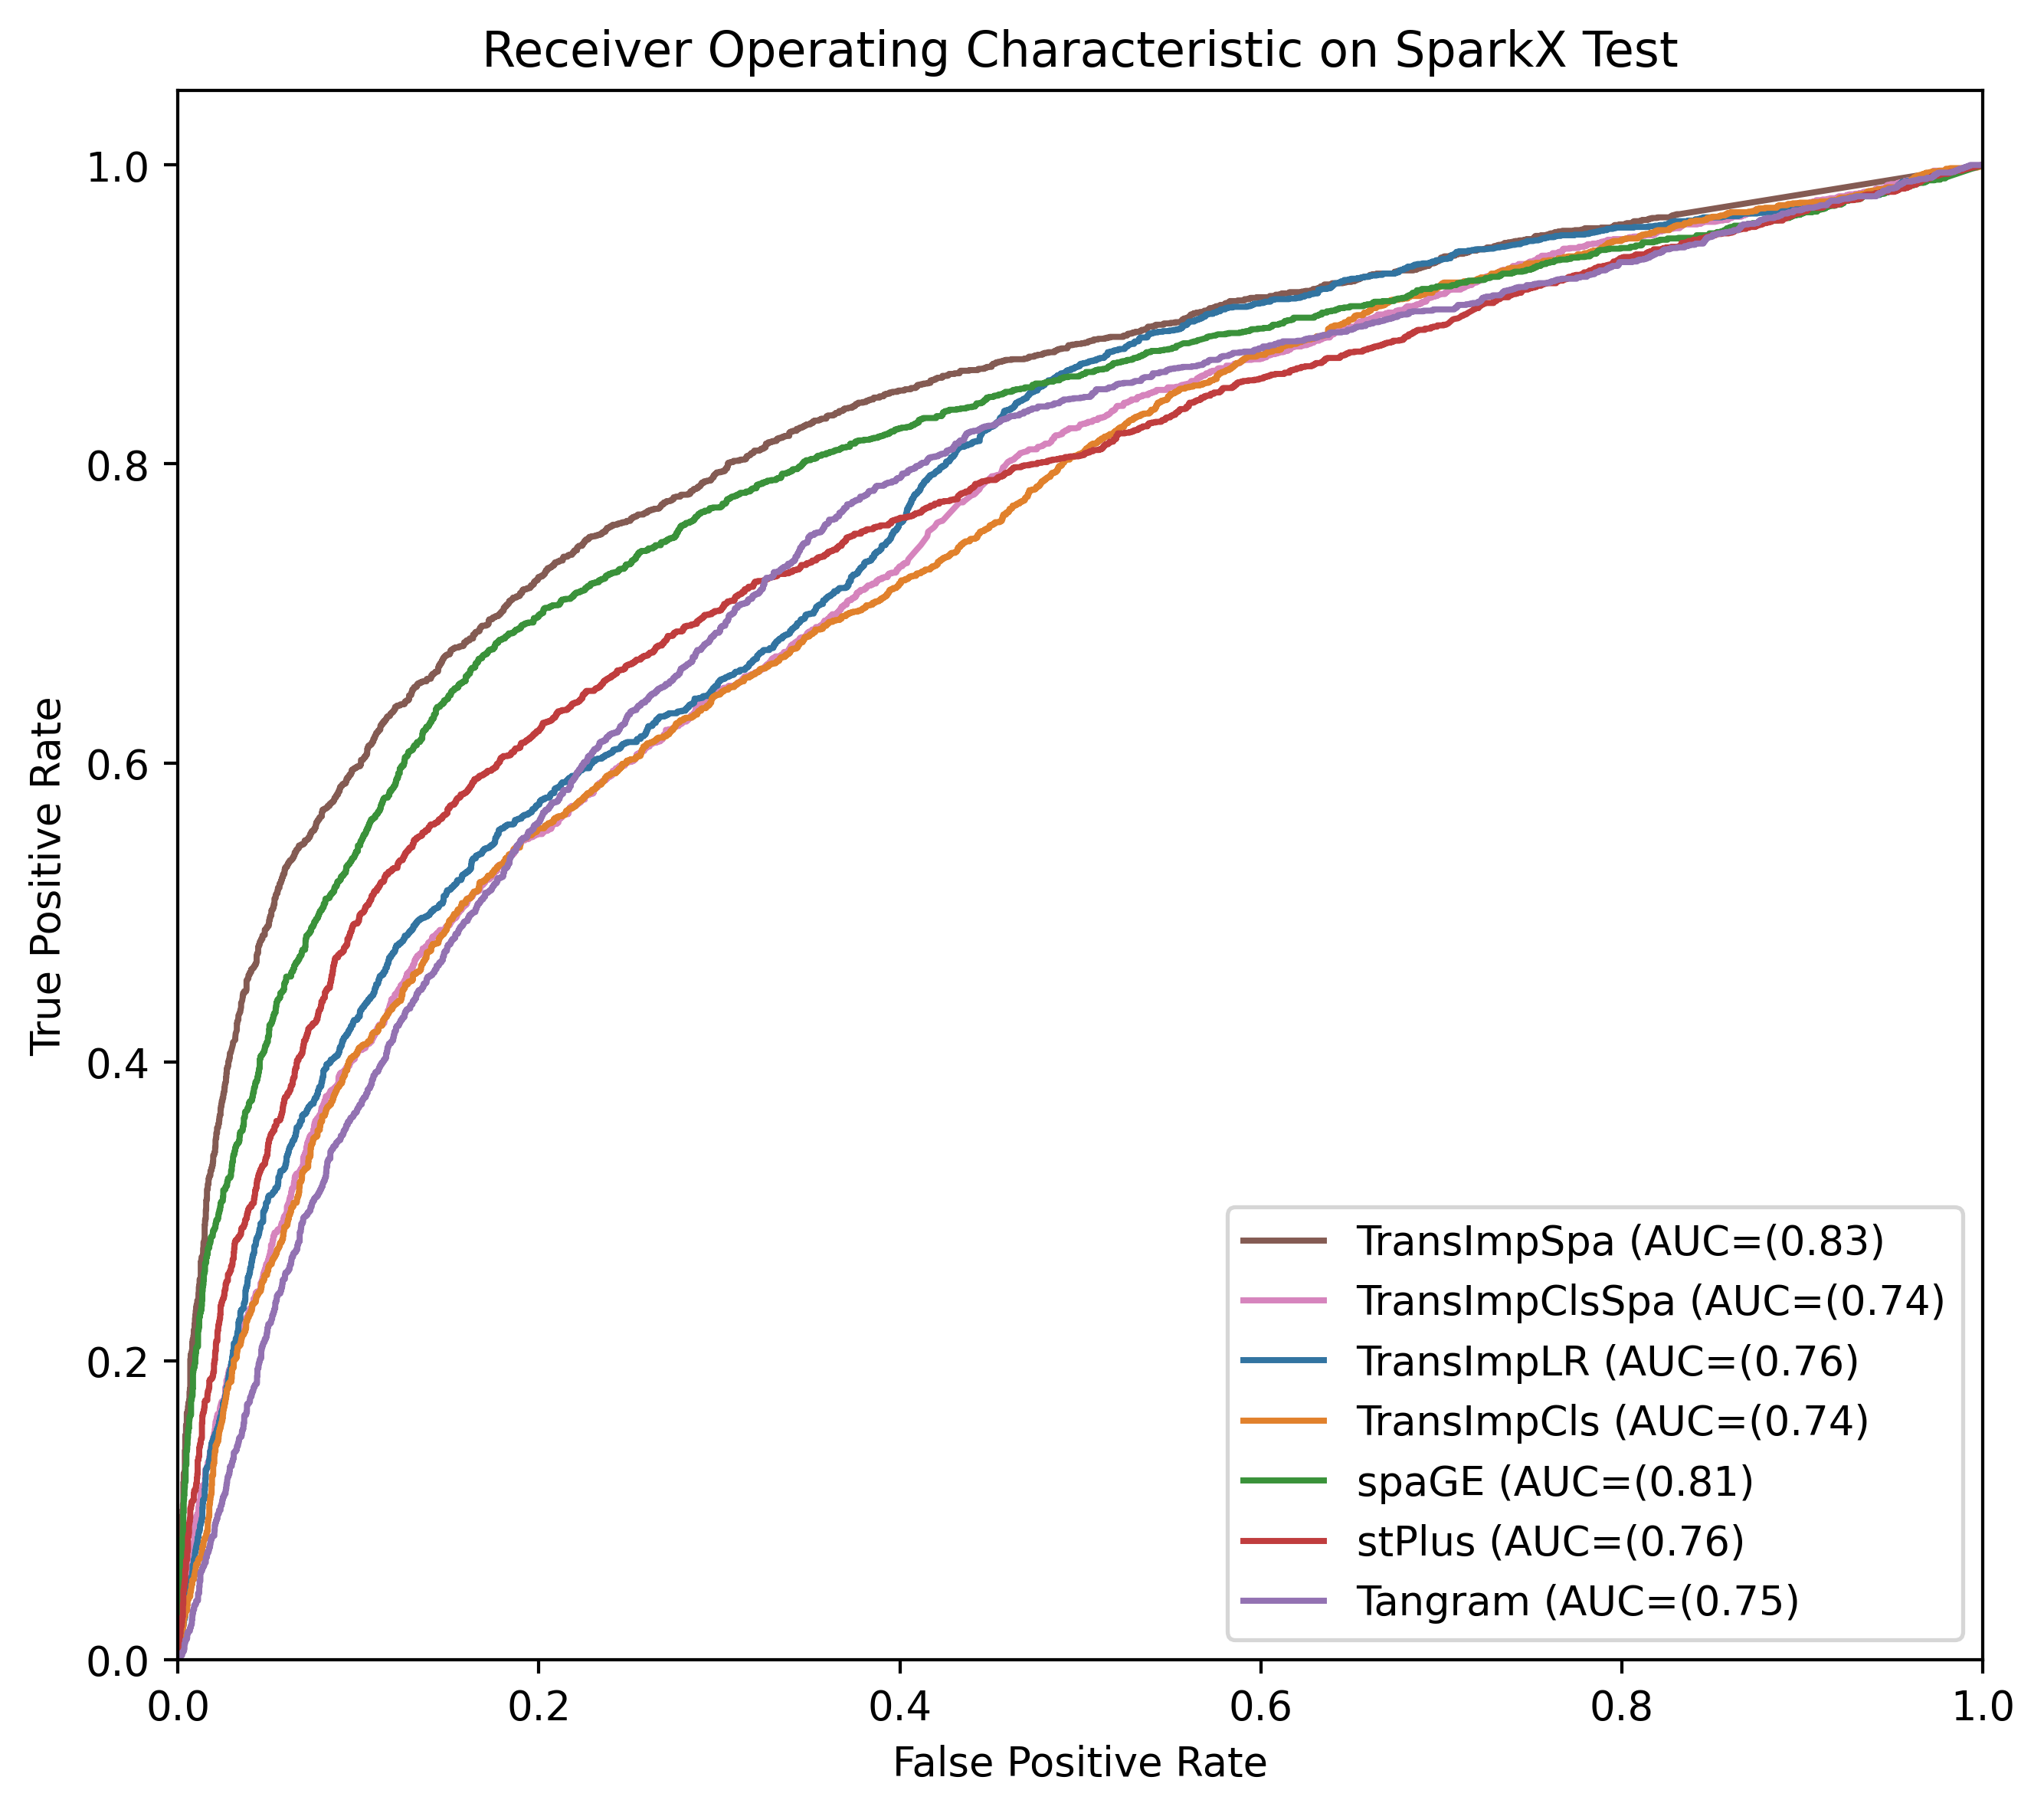

In [18]:
plot_curve_SPARKX(
                  df_sparkx_adjpvals,
                  methods, 
                  color, 
                  'roc',
                  thred=0.01,
                  excluded_items={'truth'})
                  

In [19]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    with open(pre_datapath, 'rb') as infile:
        spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992
Valid genes: 1390, Ex genes: 6992


In [20]:
for md in m_adatas:
    spatialdm(m_adatas[md], spec, 50)    

1151 1151
(1130, 9)
1151 1151
(1130, 9)
1151 1151
(1130, 9)
1151 1151
(1130, 9)
1151 1151
(1130, 9)
1151 1151
(1130, 9)
1151 1151
(1130, 11)
1151 1151
(1130, 9)


In [21]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

TransImpSpa # 721 pairs, # sig pairs: (Truth): 355, (Preds) 448
TransImpClsSpa # 721 pairs, # sig pairs: (Truth): 355, (Preds) 497
TransImpLR # 721 pairs, # sig pairs: (Truth): 355, (Preds) 430
TransImpCls # 721 pairs, # sig pairs: (Truth): 355, (Preds) 446
spaGE # 721 pairs, # sig pairs: (Truth): 355, (Preds) 359
stPlus # 721 pairs, # sig pairs: (Truth): 355, (Preds) 322
Tangram # 721 pairs, # sig pairs: (Truth): 355, (Preds) 581


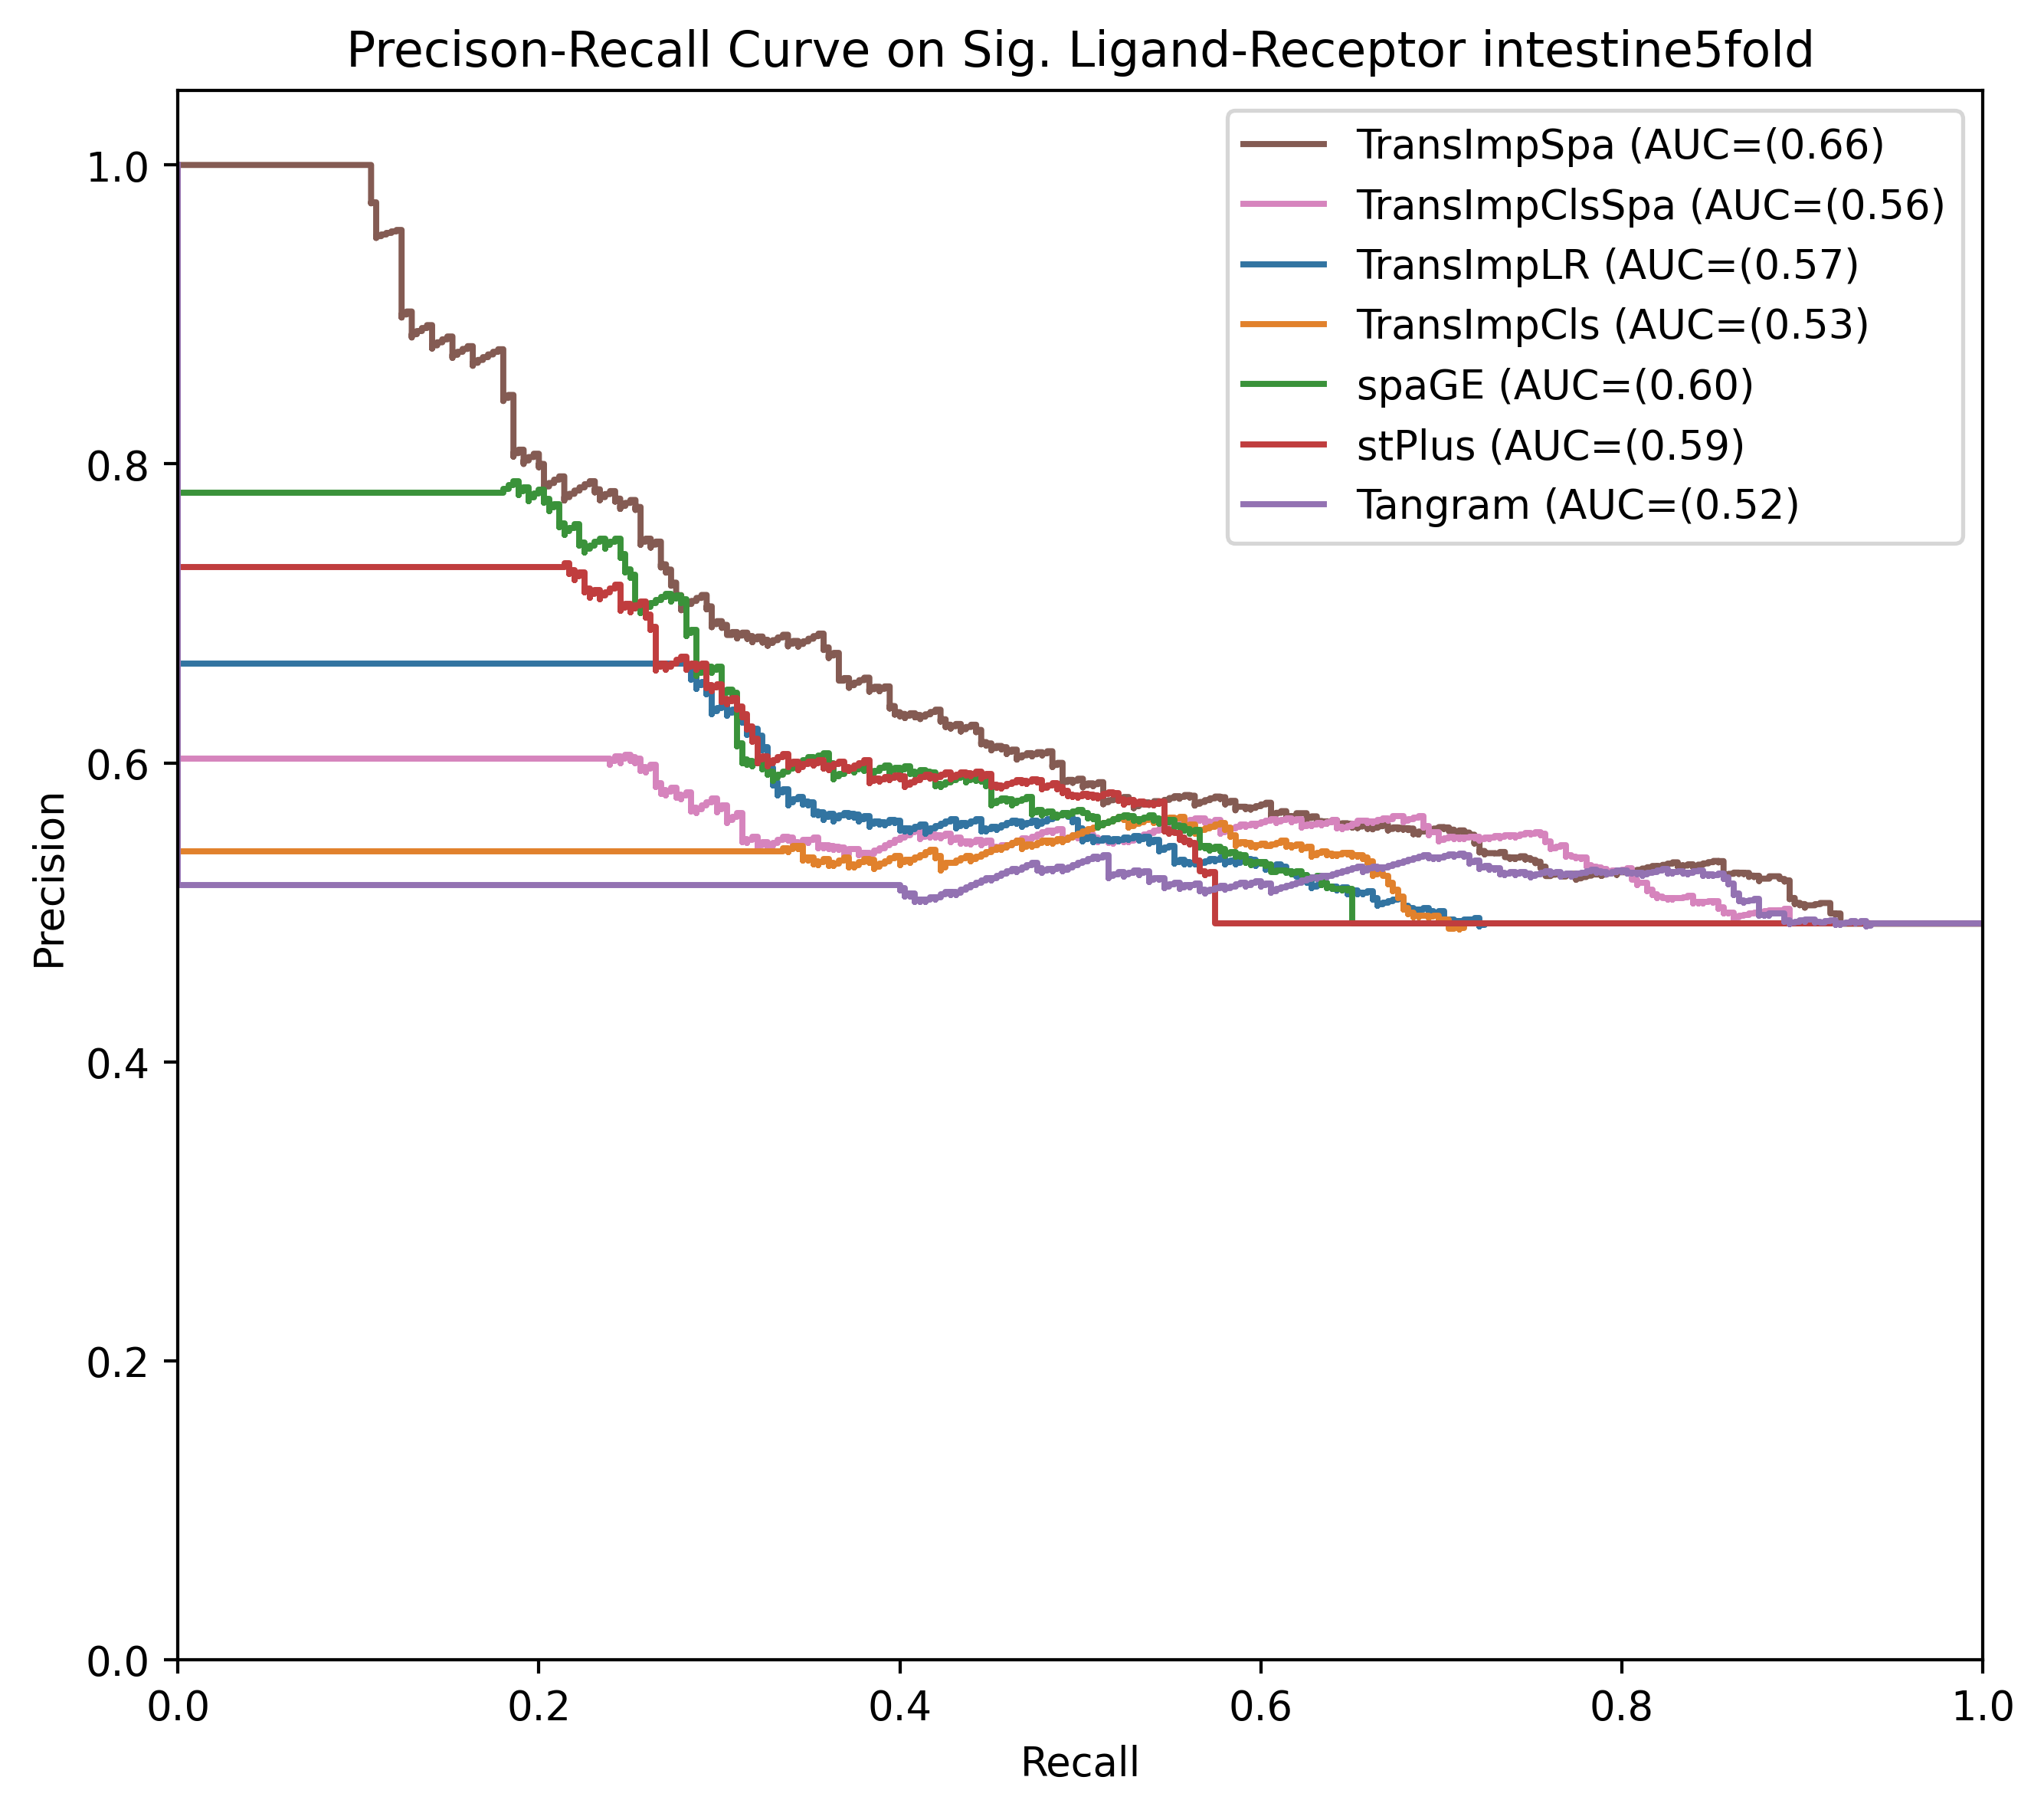

In [22]:
plot_curve_SDM(m_adatas, 
               ST_name, 
               methods, 
               color, 
               'prec_rec',
               thred=0.01,
               excluded_items={'truth'})


TransImpSpa # 721 pairs, # sig pairs: (Truth): 355, (Preds) 448
TransImpClsSpa # 721 pairs, # sig pairs: (Truth): 355, (Preds) 497
TransImpLR # 721 pairs, # sig pairs: (Truth): 355, (Preds) 430
TransImpCls # 721 pairs, # sig pairs: (Truth): 355, (Preds) 446
spaGE # 721 pairs, # sig pairs: (Truth): 355, (Preds) 359
stPlus # 721 pairs, # sig pairs: (Truth): 355, (Preds) 322
Tangram # 721 pairs, # sig pairs: (Truth): 355, (Preds) 581


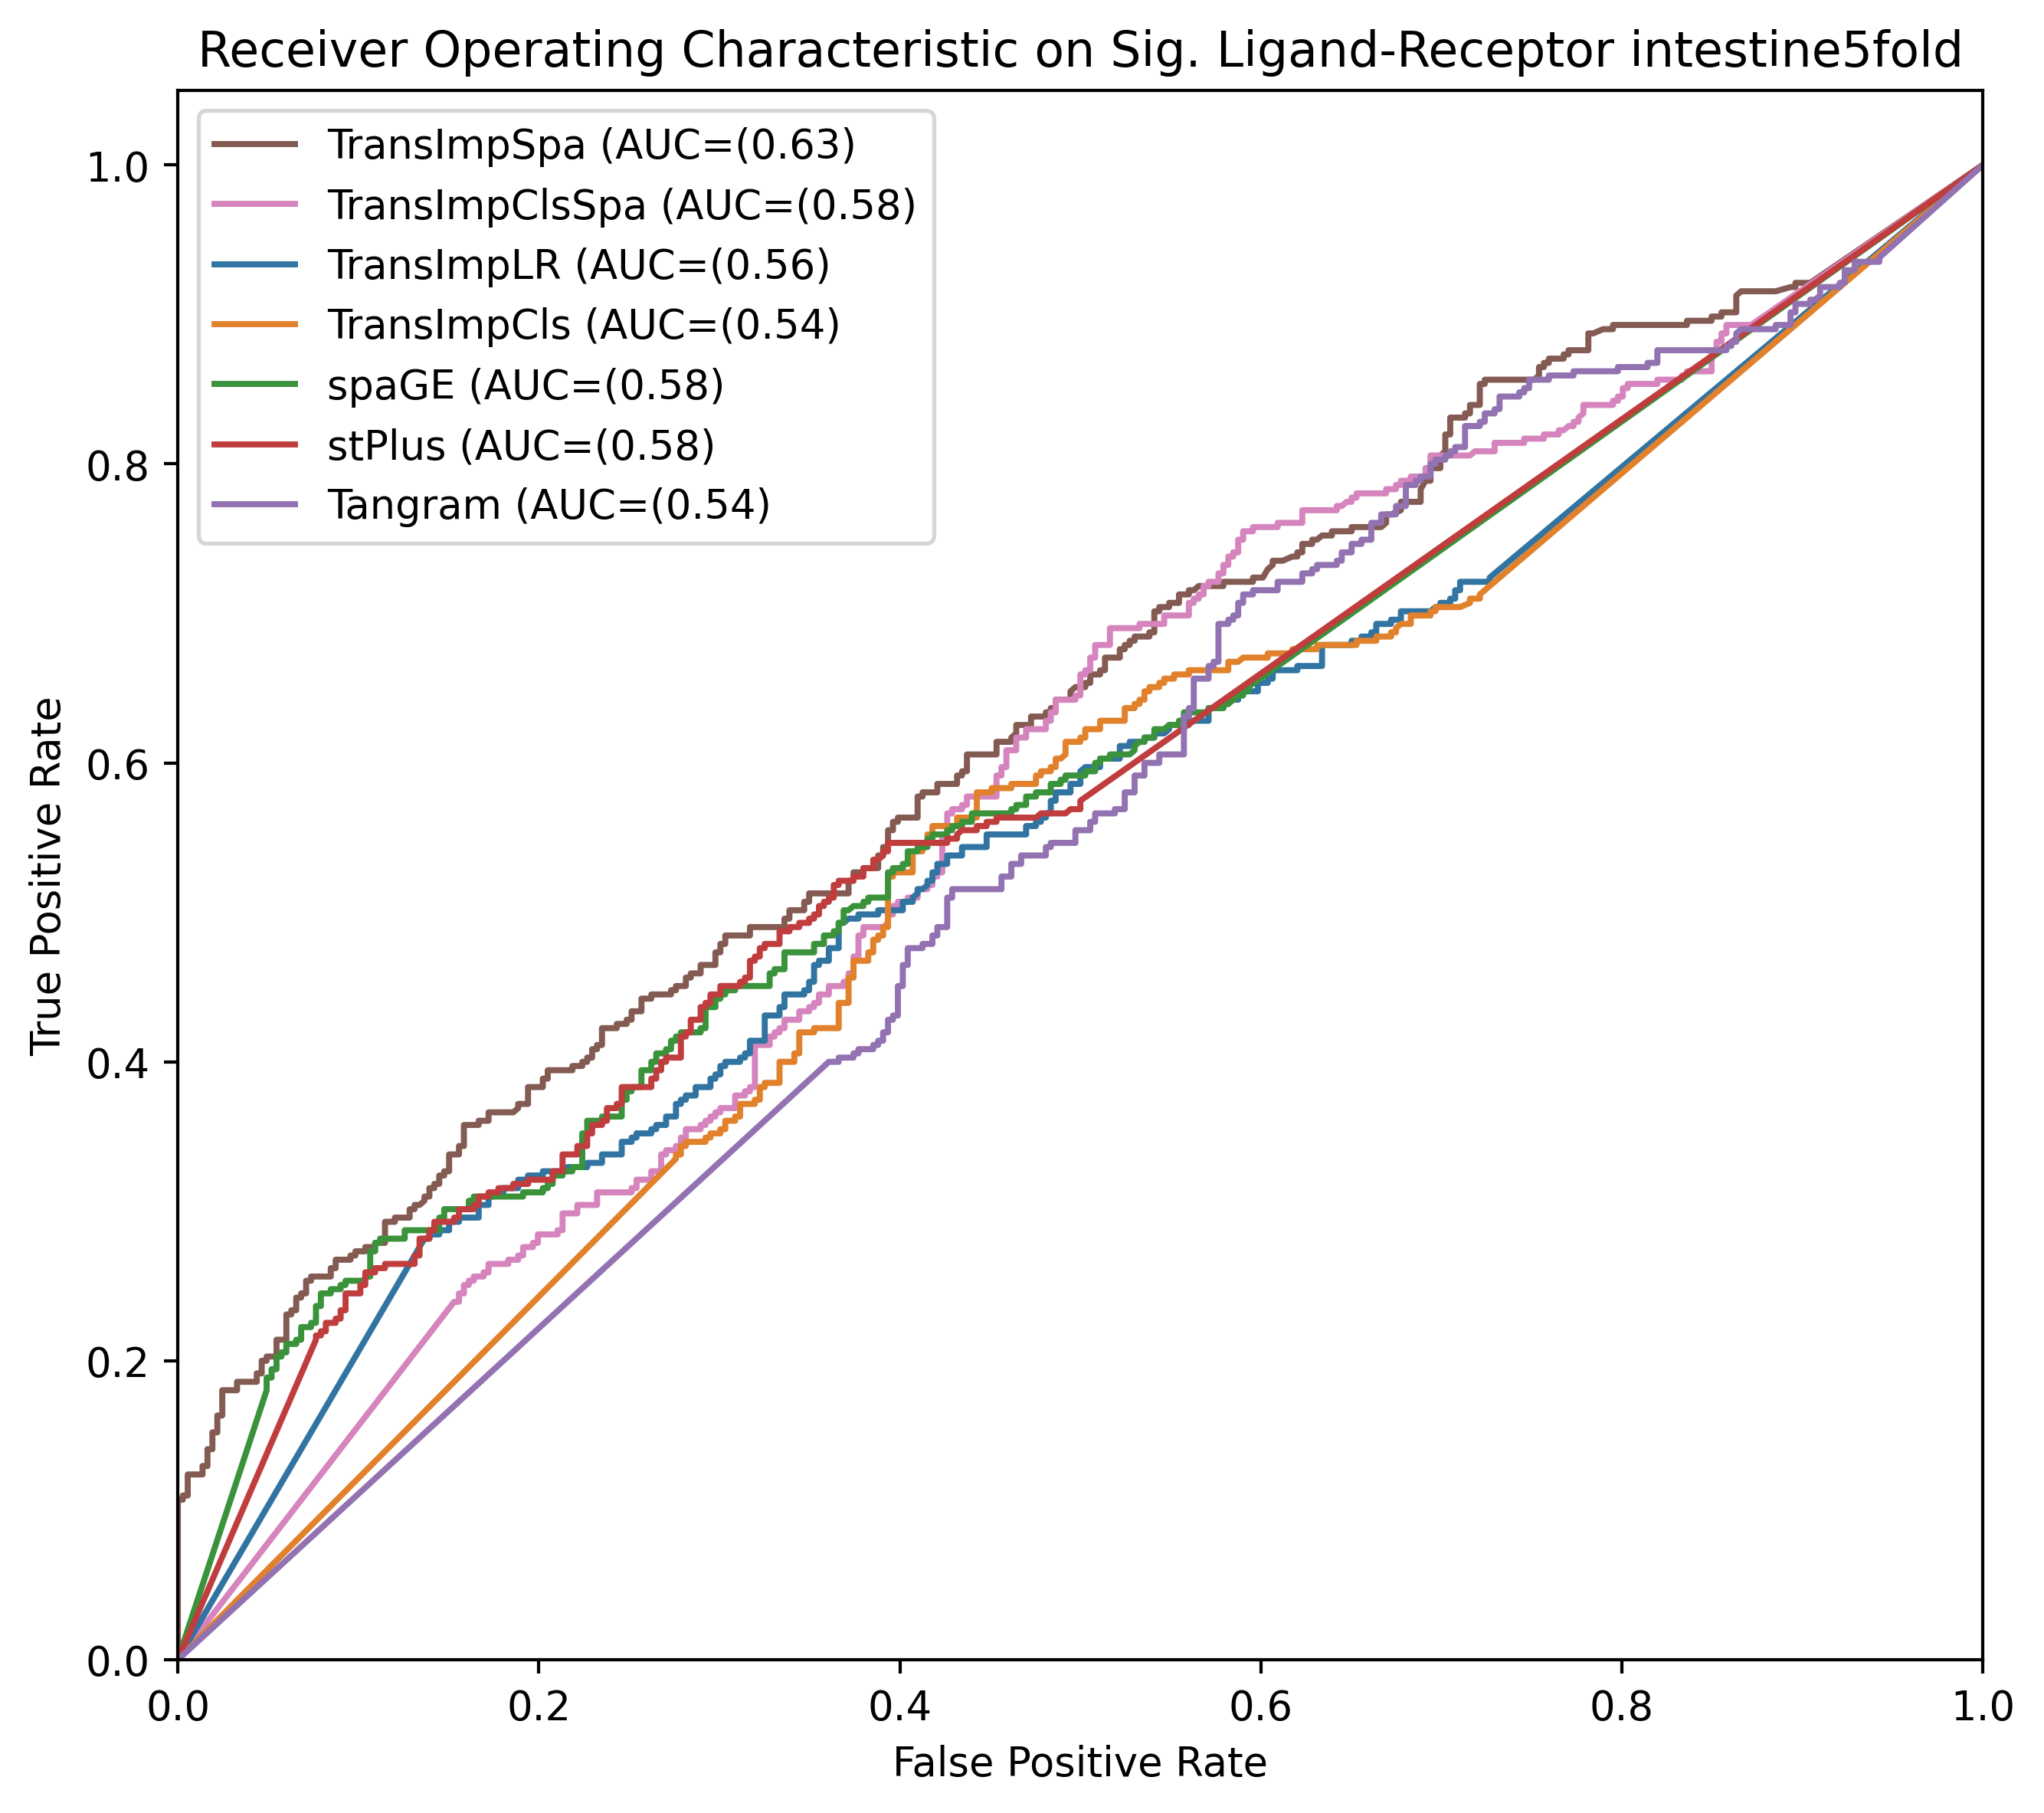

In [23]:
plot_curve_SDM(m_adatas, 
               ST_name, 
               methods, 
               color, 
               'roc',
               thred=0.01,
               excluded_items={ 'truth'})
